# Visualizing Audio as Spectrogram

An audio file has been chosen for demonstration purpose, (audio.wav). We read the .wav file and visualize it in the wave format and then in the Mel Spectrogram format with frequency bins = 128. This spectrogram will be the input to our U-Net Architecture defined in the next cell.

<class 'numpy.ndarray'> <class 'int'>
(50177,) 22050


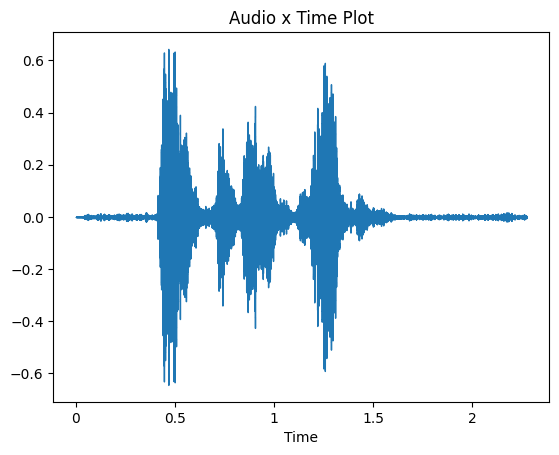

Number of frequency bins (Mel bands): 128


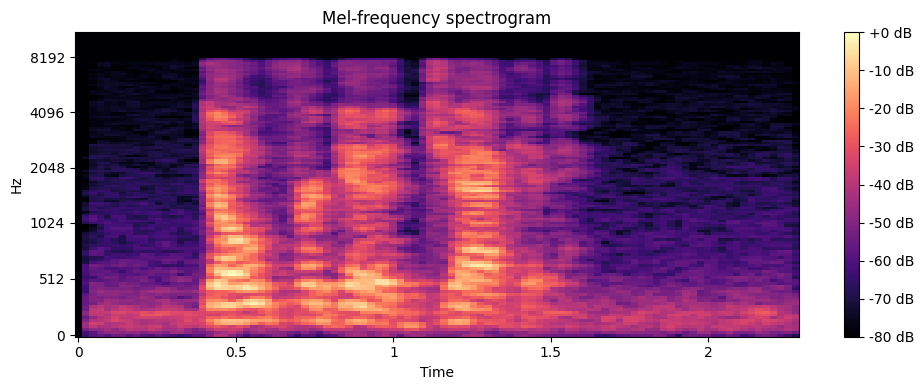

In [2]:
# Step 1. Converting Audio .wav file to Spectrogram
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
audio_path = "/content/audio.wav"

## Loading the Audio File and Visualizing it
y, sr = librosa.load(audio_path)
print(type(y), type(sr))
print(y.shape, sr)
plt.title('Audio x Time Plot')
librosa.display.waveshow(y, sr=sr)
plt.show()
## Converting to Spectrogram
# Generate Mel spectrogram
n_mels = 128  # Number of Mel bands to generate
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)

# Convert to log scale (dB)
S_dB = librosa.power_to_db(S, ref=np.max)

# Print the number of frequency bins
print(f"Number of frequency bins (Mel bands): {n_mels}")

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


# Baseline U-Net Model

The U-Net model is named after it's shape, which resembles the alphabet "U". There are Conv2D layers that expand until a bottle neck, encoding the feature representations of the input tensor. The encoded features are then upsampled from the bottleneck through ConvTranspose2d layers to reconstruct higher quality representations of the input. The Conv2D layers followed by BatchNorm2d,ReLU activations and pooling layers.

In [3]:
# Step 2: Baseline U-Net Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Contraction(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

class Expansion(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.expansion = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
    self.conv = Contraction(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.expansion(x1)
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)

class Unet(nn.Module):
  def __init__(self, n_channels, n_classes, conv_dims=128):
    super(Unet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.conv_dims = conv_dims
    #Encoder Path
    self.in_conv = Contraction(n_channels, self.conv_dims)
    self.con1 = Contraction(self.conv_dims, self.conv_dims*2)
    self.con2 = Contraction(self.conv_dims*2, self.conv_dims*4)
    self.con3 = Contraction(self.conv_dims*4, self.conv_dims*8)
    # Bottleneck
    self.con4 = Contraction(self.conv_dims*8, self.conv_dims*16)
    #Decoder Path
    self.exp1 = Expansion(self.conv_dims*16, self.conv_dims*8)
    self.exp2 = Expansion(self.conv_dims*8, self.conv_dims*4)
    self.exp3 = Expansion(self.conv_dims*4, self.conv_dims)
    #Final Layer
    self.out_conv = nn.Conv2d(self.conv_dims, n_classes, kernel_size=1)
    # Optimizer and Loss
    self.optim = torch.optim.Adam(self.parameters(), lr=0.001)
    self.loss = nn.MSEloss()

  def forward(self, x):
    x1 = self.in_conv(x)
    x2 = F.max_pool2d(x1, 2)
    x3 = F.max_pool2d(self.con1(x2), 2)
    x4 = F.max_pool2d(self.con2(x3), 2)
    x5 = F.max_pool2d(self.con3(x4), 2)
    x6 = self.con4(F.max_pool2d(x5, 2))

    x = self.exp1(x6, x5)
    x = self.exp2(x, x4)
    x = self.exp3(x,x3)
    logits = self.out_conv(x)
    return logits
  # Train - Function

  def train_model(self, train_loader, num_epochs=25):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            self.optim.zero_grad()  # Zero the parameter gradients
            outputs = self.forward(inputs)  # Forward pass
            loss = self.loss(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            self.optim.step()  # Optimize
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [ ]:
# Running the Model in Eval mode for demonstrating just the FP
model = Unet(n_channels=1,n_classes=1)
model.eval()
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

spectrogram_tensor = torch.from_numpy(spectrogram_db).unsqueeze(0).unsqueeze(0).float()

# Forward pass with a single sample
with torch.no_grad():
    output = model(spectrogram_tensor)


In [ ]:
output

tensor([[[[-0.1019, -0.0910, -0.0666, -0.0836, -0.0851, -0.0796, -0.0760,
           -0.0768, -0.0769, -0.0799, -0.0837, -0.0664, -0.0756, -0.0817,
           -0.0749, -0.0877, -0.0841, -0.0862, -0.0880, -0.0826, -0.0838,
           -0.0807, -0.0825, -0.0692],
          [-0.1026, -0.1652, -0.1189, -0.1169, -0.1071, -0.1092, -0.1072,
           -0.1104, -0.1125, -0.1066, -0.0979, -0.0973, -0.1130, -0.1078,
           -0.1056, -0.1065, -0.1142, -0.1168, -0.1167, -0.1159, -0.1148,
           -0.1211, -0.1666, -0.0996],
          [-0.1197, -0.1813, -0.1699, -0.1305, -0.1593, -0.1553, -0.1372,
           -0.1289, -0.1329, -0.1389, -0.1289, -0.1183, -0.1506, -0.1367,
           -0.1250, -0.1471, -0.1472, -0.1470, -0.1578, -0.1648, -0.1560,
           -0.1611, -0.1551, -0.0753],
          [-0.1314, -0.1850, -0.1554, -0.1181, -0.1318, -0.1095, -0.1150,
           -0.1200, -0.1135, -0.1313, -0.1308, -0.1098, -0.1312, -0.1370,
           -0.1196, -0.1320, -0.1377, -0.1380, -0.1524, -0.1512, -0.1

We perform an eval step on the model to show that the U-Net works, however, it needs to be trained with (input, output) pairs of spectrograms before it can generate accurate outputs for any input.

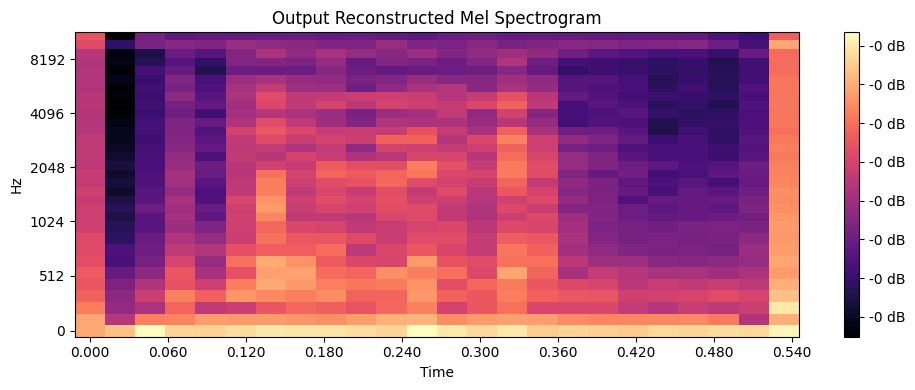

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

mel_spectrogram = output.detach().cpu().numpy()
mel_spectrogram = mel_spectrogram.squeeze()

# Plotting the Output tensor as a Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Output Reconstructed Mel Spectrogram')
plt.tight_layout()
plt.show()


We show the output of the U-Net reconstructed Spectrogram above in comparison to input Spectrogram below.

Number of frequency bins (Mel bands): 128


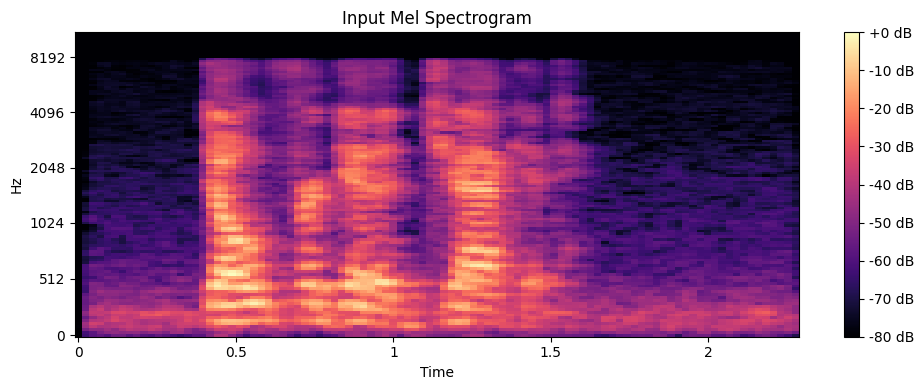

In [4]:
y, sr = librosa.load(audio_path)
n_mels = 128  # Number of Mel bands to generate
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)

# Convert to log scale (dB)
S_dB = librosa.power_to_db(S, ref=np.max)

# Print the number of frequency bins
print(f"Number of frequency bins (Mel bands): {n_mels}")

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Input Mel Spectrogram')
plt.tight_layout()
plt.show()

# Time-Shift Convolution Layers (TSConv)
To capture temporal relations between features better, we shift the input over time and perform convolution over the time-shifted input, along with Dilation. The input tensor is shifted along the time dimension using torch.roll before applying the convolution. For the padding for the shifted part, the shifted elements are made zeros.


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeShiftedConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, time_shift=0):
        super(TimeShiftedConv2D, self).__init__()
        self.time_shift = time_shift
        # Ensure the in_channels here matches the number of channels in the input tensor
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        if self.time_shift != 0:
            x = torch.roll(x, shifts=self.time_shift, dims=-1)
            if self.time_shift > 0:
                x[..., :self.time_shift] = 0
            else:
                x[..., self.time_shift:] = 0
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        return x

spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

spectrogram_tensor = torch.from_numpy(spectrogram_db).unsqueeze(0).unsqueeze(0).float()

layer = TimeShiftedConv2D(1,1,(3,3))
layer.forward(spectrogram_tensor)

tensor([[[[1.3246, 0.0131, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.2882, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.2631, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [1.2812, 1.2812, 1.2812,  ..., 1.2812, 1.2812, 1.2812],
          [1.2812, 1.2812, 1.2812,  ..., 1.2812, 1.2812, 1.2812],
          [1.2812, 1.2812, 1.2812,  ..., 1.2812, 1.2812, 1.2812]]]],
       grad_fn=<ReluBackward0>)

# U-Net with Time-Shift Convolution Layers
To add the TimeShiftedConv2D layer into the U-Net architecture, we'll follow the U-Net structure but replace the Conv2d layers with our T
imeShiftedConv2D layers.

In [ ]:

class UNetWithTimeShift(nn.Module):
    def __init__(self):
        super(UNetWithTimeShift, self).__init__()
        self.conv_dims=128
        # Adjust in_channels for the first layer to match the input tensor's channel size
        self.in_conv = TimeShiftedConv2D(1, self.conv_dims, (3, 3), padding=1, time_shift=2) # Assuming the input has 1 channel
        self.con2 = TimeShiftedConv2D(self.conv_dims, self.conv_dims*2, (3, 3), padding=1, time_shift=2)
        self.con3 = TimeShiftedConv2D(self.conv_dims*2, self.conv_dims*4, (3, 3), padding=1, time_shift=2)
        self.con4 = TimeShiftedConv2D(self.conv_dims*4, self.conv_dims*8, (3, 3), padding=1, time_shift=2)

        self.pool = nn.MaxPool2d((2, 2))

        self.exp1 = nn.ConvTranspose2d(self.conv_dims*8, self.conv_dims*4, 2, stride=2)
        self.exp1_conv1 = TimeShiftedConv2D(self.conv_dims*8, self.conv_dims*4, (3, 3), padding=1, time_shift=-2)
        self.exp2 = nn.ConvTranspose2d(self.conv_dims*4, self.conv_dims*2, 2, stride=2)
        self.exp2_conv2 = TimeShiftedConv2D(self.conv_dims*4, self.conv_dims*2, (3, 3), padding=1, time_shift=-2)
        self.exp3 = nn.ConvTranspose2d(self.conv_dims*2, self.conv_dims, 2, stride=2)
        self.exp3_conv3 = TimeShiftedConv2D(self.conv_dims*2, self.conv_dims, (3, 3), padding=1, time_shift=-2)

        self.final = nn.Conv2d(self.conv_dims, 1, kernel_size=(1, 1))

        # Optimizer and Loss
        self.optim = torch.optim.Adam(self.parameters(), lr=0.001)
        self.loss = nn.MSELoss()


    def forward(self, x):
        # Encoding path
        d1 = self.in_conv(x)
        p1 = self.pool(d1)
        d2 = self.con2(p1)
        p2 = self.pool(d2)
        d3 = self.con3(p2)
        p3 = self.pool(d3)
        d4 = self.con4(p3)

        # Decoding path + skip connections
        u3 = self.exp1(d4)
        # Resize or crop d3 to match u3's size if they don't match
        d3 = self.match_size(d3, u3)
        u3 = torch.cat((u3, d3), dim=1)
        u3 = self.exp1_conv1(u3)

        u2 = self.exp2(u3)
        # Resize or crop d2 to match u2's size
        d2 = self.match_size(d2, u2)
        u2 = torch.cat((u2, d2), dim=1)
        u2 = self.exp2_conv2(u2)

        u1 = self.exp3(u2)
        # Resize or crop d1 to match u1's size
        d1 = self.match_size(d1, u1)
        u1 = torch.cat((u1, d1), dim=1)
        u1 = self.exp3_conv3(u1)

        out = self.final(u1)
        return out

    def match_size(self, tensor_to_resize, reference_tensor):
        """
        Resize or crop the tensor_to_resize to match the spatial dimensions of the reference_tensor.
        """
        _, _, h_ref, w_ref = reference_tensor.size()
        _, _, h, w = tensor_to_resize.size()

        # If the height and width match, no need to resize or crop
        if h == h_ref and w == w_ref:
            return tensor_to_resize

        # Center crop tensor_to_resize to the size of reference_tensor
        crop_h = (h - h_ref) // 2
        crop_w = (w - w_ref) // 2

        # Adjusting for odd differences by adding 1 to the end if necessary
        return tensor_to_resize[:, :, crop_h:crop_h+h_ref, crop_w:crop_w+w_ref]

    def train_model(self, train_loader, num_epochs=25):
      for epoch in range(num_epochs):
          running_loss = 0.0
          for inputs, targets in train_loader:
              self.optim.zero_grad()  # Zero the parameter gradients
              outputs = self.forward(inputs)  # Forward pass
              loss = self.loss(outputs, targets)  # Compute loss
              loss.backward()  # Backward pass
              self.optim.step()  # Optimize
              running_loss += loss.item() * inputs.size(0)
          epoch_loss = running_loss / len(train_loader.dataset)
          print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [38]:
# Running the Model in Eval mode for demonstrating just the FP
model = UNetWithTimeShift()
model.eval()
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

spectrogram_tensor = torch.from_numpy(spectrogram_db).unsqueeze(0).unsqueeze(0).float()

# Forward pass with a single sample
with torch.no_grad():
    output = model(spectrogram_tensor)


We perform an eval step to show our model works and this model can be made better by training for more epochs using input and target outputs.

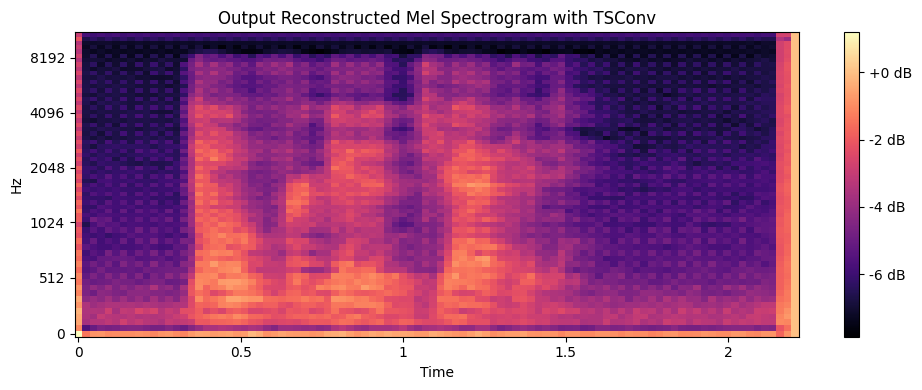

In [39]:
import librosa.display
import matplotlib.pyplot as plt

mel_spectrogram = output.detach().cpu().numpy()
mel_spectrogram = mel_spectrogram.squeeze()

# Plotting the Output tensor as a Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Output Reconstructed Mel Spectrogram with TSConv')
plt.tight_layout()
plt.show()

Number of frequency bins (Mel bands): 128


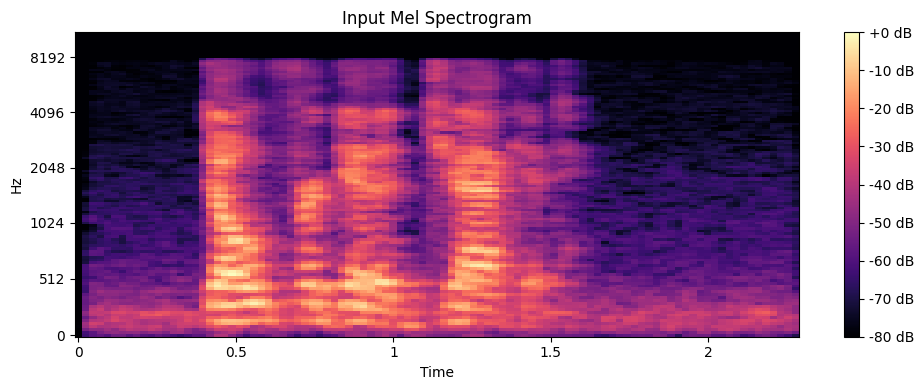

In [41]:
y, sr = librosa.load(audio_path)
n_mels = 128  # Number of Mel bands to generate
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)

# Convert to log scale (dB)
S_dB = librosa.power_to_db(S, ref=np.max)

# Print the number of frequency bins
print(f"Number of frequency bins (Mel bands): {n_mels}")

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Input Mel Spectrogram')
plt.tight_layout()
plt.show()
